GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/tanush/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/tanush/Documents/Toxicology/LLM_ModelLD50/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ NormAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ BatchNorm1d        │    600 │ train │     0 │
│ 3 │ predictor       │ RegressionFFN      │ 90.6 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 26                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


Restoring states from the checkpoint path at /home/tanush/Documents/Toxicology/LLM_ModelLD50/checkpoints/best-epoch=66-val_loss=0.3402.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/tanush/Documents/Toxicology/LLM_ModelLD50/checkpoints/best-epoch=66-val_loss=0.3402.ckpt


Output()

Restoring states from the checkpoint path at /home/tanush/Documents/Toxicology/LLM_ModelLD50/checkpoints/best-epoch=66-val_loss=0.3402.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/tanush/Documents/Toxicology/LLM_ModelLD50/checkpoints/best-epoch=66-val_loss=0.3402.ckpt



External test metrics: [{'test/mae': 0.41116660833358765, 'test/rmse': 0.5684875845909119, 'test/r2': 0.48672622442245483}]


Output()

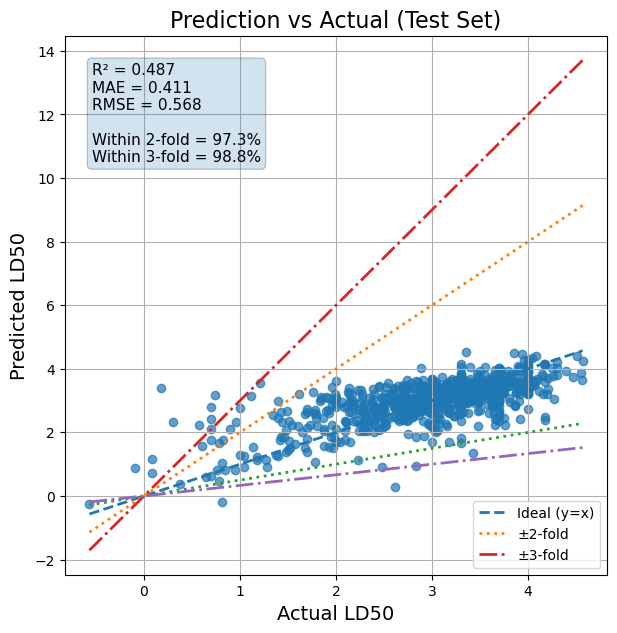

R²: 0.48672542288917164
MAE: 0.4111666357345431
RMSE: 0.5684875650924418
Within 2-fold (%): 97.30337078651685
Within 3-fold (%): 98.76404494382022


In [2]:
from pathlib import Path

from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd
from sklearn.model_selection import KFold
from chemprop import data, featurizers, models, nn
import torch
import chemprop.nn.metrics as chem_metrics
# Custom function for scaffold splitting (use your own function)
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import MolFromSmiles
import concurrent.futures
import logging
from chemprop.data import datapoints, dataloader
from chemprop.featurizers import SimpleMoleculeMolGraphFeaturizer
from chemprop.data import MoleculeDataset
from chemprop.data.datapoints import MoleculeDatapoint
# Define the function to create MoleculeDatapoints
def create_molecule_datapoints(smiles, targets):
    return [
        MoleculeDatapoint.from_smi(smi, y=target)
        for smi, target in zip(smiles, targets)
    ]

import pandas as pd
df_train = pd.read_csv('./NIHDataset/train_df.csv')
df_test = pd.read_csv('./NIHDataset/test_df.csv')
df_val = pd.read_csv('./NIHDataset/val_df.csv')
df_train = df_train.rename(columns={"SMILES_CANON": "smiles", "logLD50": "LD50"})
df_val = df_val.rename(columns={"SMILES_CANON": "smiles", "logLD50": "LD50"})
df_test = df_test.rename(columns={"SMILES_CANON": "smiles", "logLD50": "LD50"})
# Column names
smiles_column = 'smiles'
target_columns = ['LD50']
smis_test = df_test[smiles_column].values  # SMILES from test (external)
ys_test = df_test[target_columns].values  # Targets from test (external)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
num_workers = 12

# Split data

train_smis = df_train[smiles_column].values
train_targets = df_train[target_columns].values

val_smis = df_val[smiles_column].values
val_targets = df_val[target_columns].values
train_dp = create_molecule_datapoints(train_smis, train_targets)
val_dp = create_molecule_datapoints(val_smis, val_targets)
test_dp = create_molecule_datapoints(smis_test, ys_test)

train_dset = MoleculeDataset(train_dp)
val_dset = MoleculeDataset(val_dp)
test_dset = MoleculeDataset(test_dp)

# Dataloaders

train_loader = data.build_dataloader(train_dset,num_workers=num_workers,shuffle=True)

val_loader = data.build_dataloader(val_dset,num_workers=num_workers,shuffle=False)

test_loader = data.build_dataloader(test_dset,num_workers=num_workers,shuffle=False)

ffn = nn.RegressionFFN(output_transform=None)

mp = nn.BondMessagePassing(depth=5,dropout=0.1)

agg = nn.NormAggregation()

mpnn = models.MPNN(mp,agg,ffn,batch_norm=True,
                   metrics=[chem_metrics.MAE(),
                            chem_metrics.RMSE(),
                            chem_metrics.R2Score()])

# Per-fold checkpoint dir
    
ckpt_dir = Path(f"./checkpoints/")
ckpt_dir.mkdir(parents=True, exist_ok=True)

checkpoint_cb = ModelCheckpoint(dirpath=ckpt_dir,filename="best-{epoch}-{val_loss:.4f}",
                                monitor="val_loss",mode="min",save_last=True)

# -------------------------
# Trainer
# -------------------------
trainer = pl.Trainer(accelerator="auto",devices=1,
                     max_epochs=100,logger=False,
                     callbacks=[checkpoint_cb],
                     enable_progress_bar=True)


# Train

trainer.fit(mpnn, train_loader, val_loader)



external_test_metrics = []

# External (test)
test_metrics = trainer.test(
    mpnn,
    dataloaders=test_loader,
    ckpt_path="best",
    weights_only=False,
    verbose=False,
)[0]

external_test_metrics.append(test_metrics)

print("\nExternal test metrics:", external_test_metrics)
# Get predictions
preds = trainer.predict(
    mpnn,
    dataloaders=test_loader,
    ckpt_path="best",
    weights_only=False   # <-- IMPORTANT
)

# Flatten predictions correctly
y_pred = torch.cat(preds).squeeze().cpu().numpy()

# True values
y_true = ys_test.flatten()

# DataFrame
test_results = pd.DataFrame({
    "actual": y_true,
    "predicted": y_pred
})

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def plot_with_metrics(df, true_col="True_LD50", pred_col="Pred_LD50"):
    
    y_true = df[true_col].values
    y_pred = df[pred_col].values

    # ---- Metrics ----
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # ---- Fold errors ----
    fold_error = np.maximum(y_pred/y_true, y_true/y_pred)

    within_2fold = np.mean(fold_error <= 2) * 100
    within_3fold = np.mean(fold_error <= 3) * 100

    # ---- Plot ----
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    x = np.linspace(min_val, max_val, 100)

    plt.figure(figsize=(7,7))

    plt.scatter(y_true, y_pred, alpha=0.7)

    # Ideal
    plt.plot(x, x, linestyle='--', linewidth=2, label="Ideal (y=x)")

    # 2-fold
    plt.plot(x, 2*x, linestyle=':', linewidth=2, label="±2-fold")
    plt.plot(x, x/2, linestyle=':', linewidth=2)

    # 3-fold
    plt.plot(x, 3*x, linestyle='-.', linewidth=2, label="±3-fold")
    plt.plot(x, x/3, linestyle='-.', linewidth=2)

    # ---- Text box ----
    textstr = (
        f"R² = {r2:.3f}\n"
        f"MAE = {mae:.3f}\n"
        f"RMSE = {rmse:.3f}\n\n"
        f"Within 2-fold = {within_2fold:.1f}%\n"
        f"Within 3-fold = {within_3fold:.1f}%"
    )

    plt.text(0.05, 0.95, textstr,
             transform=plt.gca().transAxes,
             fontsize=11,
             verticalalignment='top',
             bbox=dict(boxstyle="round", alpha=0.2))

    plt.xlabel("Actual LD50", fontsize=14)
    plt.ylabel("Predicted LD50", fontsize=14)
    plt.title("Prediction vs Actual (Test Set)", fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print metrics also
    print("R²:", r2)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("Within 2-fold (%):", within_2fold)
    print("Within 3-fold (%):", within_3fold)
    
plot_with_metrics(test_results, true_col="actual",pred_col="predicted")

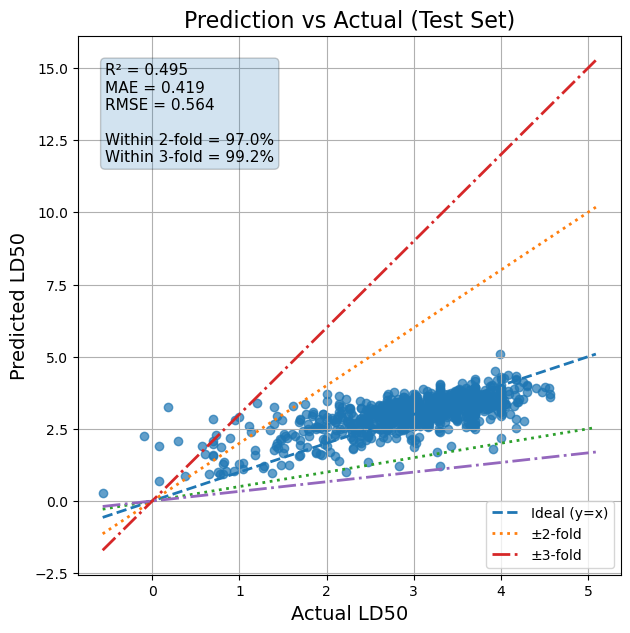

R²: 0.4949392978118451
MAE: 0.4189101202215851
RMSE: 0.5639204987830883
Within 2-fold (%): 96.96629213483146
Within 3-fold (%): 99.21348314606742


In [3]:
plot_with_metrics(test_results, true_col="actual",pred_col="predicted")